In [1]:
import pandas as pd
import numpy as np
#import geopandas as gpd
#import dask.dataframe as dd
#from dask.diagnostics import ProgressBar
from datetime import datetime
from matplotlib import pyplot as plt
import scipy


import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Data Downloading & Preprocessing

### 1.1 Uber&lyft Dataset Downloading 


In [2]:
#download hvfhv data from 2019.02-2020.12
import requests
def downloadData():
    csv_url_head = 'https://s3.amazonaws.com/nyc-tlc/trip+data/fhvhv_tripdata_'  
    for year in ['2019','2020']:
        for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
            req = requests.get(csv_url_head+year+'-'+month+'.csv')
            url_content = req.content
            csv_file = open('hvfhv_tripdata_'+year+'-'+month+'.csv', 'wb')
            csv_file.write(url_content)
            csv_file.close()
#!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-01.csv > yellow_tripdata_2020-01.csv    
downloadData()

In [1]:
#download fhvdata from 2018.01-2019.01
import requests
def downloadData():
    csv_url_head = 'https://s3.amazonaws.com/nyc-tlc/trip+data/fhv_tripdata_'  
    for year in ['2018','2019']:
        for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
            if year=='2019' and month>='02' :continue
            req = requests.get(csv_url_head+year+'-'+month+'.csv')
            url_content = req.content
            csv_file = open('fhv_tripdata_'+year+'-'+month+'.csv', 'wb')
            csv_file.write(url_content)
            csv_file.close()
#!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-01.csv > yellow_tripdata_2020-01.csv    
downloadData()

In [4]:
#extract uber data of 2018.01-2019.01 from fhv data
hvfhv = dd.read_csv('hvfhv_tripdata_20*.csv', 
                usecols=['hvfhs_license_num','dispatching_base_num'])
uber_baseNo_list = hvfhv[hvfhv['hvfhs_license_num']=='HV0003']['dispatching_base_num'].unique().compute()

In [2]:
uber_baseNo_list = ['B02867',
 'B02879',
 'B02764',
 'B02864',
 'B02875',
 'B02682',
 'B02617',
 'B02836',
 'B02887',
 'B02880',
 'B02765',
 'B02882',
 'B02888',
 'B02869',
 'B02884',
 'B02835',
 'B02878',
 'B02889',
 'B02871',
 'B02395',
 'B02866',
 'B02872',
 'B02883',
 'B02876',
 'B02877',
 'B02870',
 'B02865']

In [18]:
fhv_2018 = dd.read_csv('fhv_tripdata_2018*.csv',dtype={'DOlocationID': 'float64',
       'PUlocationID': 'float64'},usecols=['Dispatching_base_number','Pickup_DateTime','DropOff_datetime','PUlocationID','DOlocationID'])

fhv_201901 = dd.read_csv('fhv_tripdata_2019-01.csv',dtype={'DOlocationID': 'float64',
       'PUlocationID': 'float64'},usecols=['dispatching_base_num','pickup_datetime','dropoff_datetime','PULocationID','DOLocationID'])

uber_part1_2018 = fhv_2018[fhv_2018['Dispatching_base_number'].isin(list(uber_baseNo_list))].compute()
uber_part1_201901 = fhv_201901[fhv_201901['dispatching_base_num'].isin(list(uber_baseNo_list))].compute()

uber_part1_2018.drop(columns=['Dispatching_base_number'],inplace=True)
uber_part1_201901.drop(columns=['dispatching_base_num'],inplace=True)
uber_part1_201901.columns = list(uber_part1_2018.columns)

uber_part1 = pd.concat([uber_part1_2018,uber_part1_201901],ignore_index=True)
uber_part1.to_csv("uber_data_raw_201801-201901.csv")

In [16]:
#merge uber data
hvfhv = dd.read_csv('hvfhv_tripdata_20*.csv',dtype={'DOLocationID': 'float64',
       'PULocationID': 'float64'},usecols=['hvfhs_license_num','pickup_datetime','dropoff_datetime','PULocationID','DOLocationID'])

In [7]:
uber_part2 = hvfhv[hvfhv['hvfhs_license_num']=='HV0003'].compute()
uber_part2 = uber_part2.loc[:,['pickup_datetime','dropoff_datetime','PULocationID','DOLocationID']]
uber_part2.columns= list(uber_part1.columns)
uber_part2.to_csv("uber_data_raw_201902-202012.csv")

In [9]:
#uber_part2 = dd.read_csv('uber_data_raw_201902-202012.csv')
uber_part1 = dd.read_csv('uber_data_raw_201801-201901.csv')

In [3]:
uber_complete['Pickup_DateTime'] = dd.to_datetime(uber_complete['Pickup_DateTime'])
uber_complete['PU_Date'] = uber_complete['Pickup_DateTime'].dt.normalize()
uber_complete['PU_Time'] = uber_complete['Pickup_DateTime'].dt.hour

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/jw6830/capstone project/uber_data_raw_201801-202012.csv'

In [11]:
%time Uber_aggby_count_part2 = uber_complete.groupby(['PU_Date','PU_Time','PUlocationID']).count()[['DOLocationID']].compute()
Uber_aggby_count_part2.reset_index(inplace=True)

CPU times: user 4min 49s, sys: 23.1 s, total: 5min 12s
Wall time: 3min


In [12]:
Uber_aggby_count_part2.rename({"DOLocationID":"PU_cnt"})
Uber_aggby_count_part2['PU_Year'] = Uber_aggby_count_part2['PU_Date'].dt.year
Uber_aggby_count_part2['PU_Month'] = Uber_aggby_count_part2['PU_Date'].dt.month
Uber_aggby_count_part2['PU_Weekday'] = Uber_aggby_count_part2['PU_Date'].dt.day_name()

In [13]:
def time_slots(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,17):
        return 'Afternoon'
    elif x in range(17,22):
        return 'Evening'
    else:
        return 'Late Night'
def season_tag(x):
    if x in (1,2,12):
        return 'Winter'
    elif x in range(3,6):
        return 'Spring'
    elif x in range(6,9):
        return 'Summer'
    else:
        return 'Autumn'
    
Uber_aggby_count_part2['time_desc'] = Uber_aggby_count_part2['PU_Time'].apply(time_slots)
Uber_aggby_count_part2['season'] = Uber_aggby_count_part2['PU_Month'].apply(season_tag)

In [14]:
Uber_aggby_count = pd.concat([Uber_aggby_count_part1,Uber_aggby_count_part2],ignore_index=True)

In [15]:
Uber_aggby_count.to_csv("Uber_dailyRidership_count_18-20.csv")

In [22]:
#extract lyft data of 2018.01-2019.01 from fhv data
lyft_baseNo_list = hvfhv[hvfhv['hvfhs_license_num']=='HV0005']['dispatching_base_num'].unique().compute()

In [23]:
lyft_baseNo_list

0    B02510
1    B02844
Name: dispatching_base_num, dtype: object

In [19]:
fhv_2018 = dd.read_csv('fhv_tripdata_2018*.csv',dtype={'DOlocationID': 'float64',
       'PUlocationID': 'float64'},usecols=['Dispatching_base_number','Pickup_DateTime','DropOff_datetime','PUlocationID','DOlocationID'])

fhv_201901 = dd.read_csv('fhv_tripdata_2019-01.csv',dtype={'DOlocationID': 'float64',
       'PUlocationID': 'float64'},usecols=['dispatching_base_num','pickup_datetime','dropoff_datetime','PULocationID','DOLocationID'])

lyft_part1_2018 = fhv_2018[fhv_2018['Dispatching_base_number'].isin(['B02510','B02844'])].compute()
lyft_part1_201901 = fhv_201901[fhv_201901['dispatching_base_num'].isin(['B02510','B02844'])].compute()

lyft_part1_2018.drop(columns=['Dispatching_base_number'],inplace=True)
lyft_part1_201901.drop(columns=['dispatching_base_num'],inplace=True)
lyft_part1_201901.columns = list(lyft_part1_2018.columns)

lyft_part1 = pd.concat([lyft_part1_2018,lyft_part1_201901],ignore_index=True)
lyft_part1.to_csv("lyft_data_raw_201801-201901.csv")

In [21]:
#lyft_part2 = hvfhv[hvfhv['hvfhs_license_num']=='HV0005'].compute()
#lyft_part2 = lyft_part2.loc[:,['pickup_datetime','dropoff_datetime','PULocationID','DOLocationID']]
lyft_part2.columns= list(lyft_part1.columns)
lyft_part2.to_csv("lyft_data_raw_201902-202012.csv")

In [25]:
#uber_complete = dd.read_csv('uber_data_raw_201801-202012.csv')
lyft_part2['Pickup_DateTime'] = dd.to_datetime(lyft_part2['Pickup_DateTime'])
lyft_part2['PU_Date'] = lyft_part2['Pickup_DateTime'].dt.normalize()
lyft_part2['PU_Time'] = lyft_part2['Pickup_DateTime'].dt.hour

%time lyft_aggby_count_part2 = lyft_part2.groupby(['PU_Date','PU_Time']).count()[['PUlocationID']]
lyft_aggby_count_part2.reset_index(inplace=True)
lyft_aggby_count_part2.rename({"PUlocationID":"PU_cnt"})

lyft_aggby_count_part2['PU_Year'] = lyft_aggby_count_part2['PU_Date'].dt.year
lyft_aggby_count_part2['PU_Month'] = lyft_aggby_count_part2['PU_Date'].dt.month
lyft_aggby_count_part2['PU_Weekday'] = lyft_aggby_count_part2['PU_Date'].dt.day_name()
lyft_aggby_count_part2['time_desc'] = lyft_aggby_count_part2['PU_Time'].apply(time_slots)
lyft_aggby_count_part2['season'] = lyft_aggby_count_part2['PU_Month'].apply(season_tag)


CPU times: user 14.7 s, sys: 2.25 s, total: 16.9 s
Wall time: 17 s


In [26]:
lyft_aggby_count_part2.PU_Year.value_counts()

2020    8772
2019    8015
Name: PU_Year, dtype: int64

In [27]:
lyft_aggby_count = pd.concat([lyft_aggby_count_part1,lyft_aggby_count_part2],ignore_index=True)
lyft_aggby_count.to_csv("lyft_dailyRidership_count_18-20.csv")

### 1.2.green&yellow Dataset Downloading

In [2]:
#download greentaxidata from 2018.01-2020.12
import requests
def downloadData():
    csv_url_head = 'https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_'  
    for year in ['2018','2019','2020']:
        for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
            req = requests.get(csv_url_head+year+'-'+month+'.csv')
            url_content = req.content
            csv_file = open('green_tripdata_'+year+'-'+month+'.csv', 'wb')
            csv_file.write(url_content)
            csv_file.close()
#!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-01.csv > yellow_tripdata_2020-01.csv    
downloadData()

In [3]:
#download yellowtaxidata from 2018.01-2020.12
import requests
def downloadData():
    csv_url_head = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_'  
    for year in ['2018','2019','2020']:
        for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:
            req = requests.get(csv_url_head+year+'-'+month+'.csv')
            url_content = req.content
            csv_file = open('yellow_tripdata_'+year+'-'+month+'.csv', 'wb')
            csv_file.write(url_content)
            csv_file.close()
#!curl https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2020-01.csv > yellow_tripdata_2020-01.csv    
downloadData()

In [2]:
hvfhv = dd.read_csv('hvfhv_tripdata_20*.csv', 
                 dtype={'PULocationID': 'float64'},
                usecols=['hvfhs_license_num','dispatching_base_num','pickup_datetime','PULocationID'])

### data preprocessing

In [ ]:
Uber_data = dd.read_csv('uber_data_raw_201801-202012.csv')

In [3]:
hvfhv['pickup_datetime'] = dd.to_datetime(hvfhv['pickup_datetime'])
hvfhv['PU_Date'] = hvfhv['pickup_datetime'].dt.normalize()
hvfhv['PU_Month'] = hvfhv['pickup_datetime'].dt.month
hvfhv['PU_Time'] = hvfhv['pickup_datetime'].dt.hour
hvfhv['PU_Weekday'] = hvfhv['pickup_datetime'].dt.day_name()

In [4]:
def time_slots(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,17):
        return 'Afternoon'
    elif x in range(17,22):
        return 'Evening'
    else:
        return 'Late Night'
def season_tag(x):
    if x in (1,2,12):
        return 'Winter'
    elif x in range(3,6):
        return 'Spring'
    elif x in range(6,9):
        return 'Summer'
    else:
        return 'Autumn'
    
hvfhv['time_desc'] = hvfhv['PU_Time'].apply(time_slots)
hvfhv['season'] = hvfhv['PU_Month'].apply(season_tag)

In [5]:
#keep taxi records from Uber company
%time Uber_data = hvfhv[hvfhv['hvfhs_license_num']=='HV0003'].compute()
#drop rows with unusual date
%time Uber_data = Uber_data[(Uber_data['pickup_datetime'].dt.year >2018) & (Uber_data['pickup_datetime'].dt.year <=2020)]

CPU times: user 16min 19s, sys: 1min 25s, total: 17min 45s
Wall time: 14min 20s
CPU times: user 1min 15s, sys: 22.5 s, total: 1min 37s
Wall time: 1min 38s


In [6]:
#cal = calander()
#holidays = cal.holidays(start='2019-01-01', end='2020-12-31')
#Uber_data['PU_holiday'] = Uber_data['PU_Date'].isin(holidays)
Uber_data['PU_DOW'] = Uber_data['PU_Date'].dt.dayofweek

#Uber_data.loc[Uber_data['PU_week'] >= 5, 'day_type'] = "weekend"
#Uber_data.loc[Uber_data['PU_week'] < 5, 'day_type'] = "workday"
#Uber_data.loc[Uber_data['holiday'] == True, 'day_type'] = "holiday"
#Uber_data = Uber_data.drop(['holiday', 'week'], axis=1)
Uber_data['PU_year'] = Uber_data['pickup_datetime'].dt.year

In [7]:
#output uber data to csv and save for next time use
Uber_data.to_csv("uber_data_19-20.csv")

In [3]:
Uber_data = dd.read_csv('uber_data_19-20.csv')

In [4]:
Uber_data.head()

,Unnamed: 0,hvfhs_license_num,dispatching_base_num,pickup_datetime,PULocationID,PU_Date,PU_Month,PU_Time,PU_Weekday,time_desc,season,PU_DOW,PU_year
0,0,HV0003,B02867,2019-02-01 00:05:18,245.0,2019-02-01 00:00:00,2,0,Friday,Late Night,Winter,4,2019
1,1,HV0003,B02879,2019-02-01 00:41:29,216.0,2019-02-01 00:00:00,2,0,Friday,Late Night,Winter,4,2019
2,8,HV0003,B02867,2019-02-01 00:10:48,226.0,2019-02-01 00:00:00,2,0,Friday,Late Night,Winter,4,2019
3,9,HV0003,B02867,2019-02-01 00:32:32,7.0,2019-02-01 00:00:00,2,0,Friday,Late Night,Winter,4,2019
4,10,HV0003,B02867,2019-02-01 00:59:54,129.0,2019-02-01 00:00:00,2,0,Friday,Late Night,Winter,4,2019


### 1.1 average ridership between different time slot and day of week on different season(barplot)

In [92]:
%time Uber_aggby_count = Uber_data.groupby(['PU_year','season','PU_Weekday','PU_Date','time_desc']).count()[['PULocationID']].compute()
Uber_aggby_count.reset_index(inplace=True)

CPU times: user 7min 32s, sys: 1min 42s, total: 9min 15s
Wall time: 4min 29s


In [93]:
%time Uber_aggby_avg = Uber_aggby_count.groupby(['PU_year','season','PU_Weekday','time_desc']).mean()[['PULocationID']]
Uber_aggby_avg.reset_index(inplace=True)

CPU times: user 4.6 ms, sys: 1.97 ms, total: 6.57 ms
Wall time: 5.16 ms


In [94]:
Uber_aggby_avg.head()

,PU_year,season,PU_Weekday,time_desc,PULocationID
0,2019,Autumn,Friday,Afternoon,114645.076923
1,2019,Autumn,Friday,Evening,162410.230769
2,2019,Autumn,Friday,Late Night,126085.076923
3,2019,Autumn,Friday,Morning,125991.846154
4,2019,Autumn,Monday,Afternoon,96364.307692


In [95]:
Uber_aggby_avg.rename(columns={'PULocationID':'avg_trips'},inplace=True)
Uber_aggby_avg['avg_trips']=Uber_aggby_avg['avg_trips'].astype('int64')

In [96]:
agg_2019_winter= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2019)&(Uber_aggby_avg['season']=='Winter')]
agg_2019_summer= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2019)&(Uber_aggby_avg['season']=='Summer')]
agg_2020_winter= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2020)&(Uber_aggby_avg['season']=='Winter')]
agg_2020_summer= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2020)&(Uber_aggby_avg['season']=='Summer')]

In [97]:
agg_2019_winter.head()

,PU_year,season,PU_Weekday,time_desc,avg_trips
84,2019,Winter,Friday,Afternoon,119091
85,2019,Winter,Friday,Evening,174791
86,2019,Winter,Friday,Late Night,126902
87,2019,Winter,Friday,Morning,131031
88,2019,Winter,Monday,Afternoon,106170


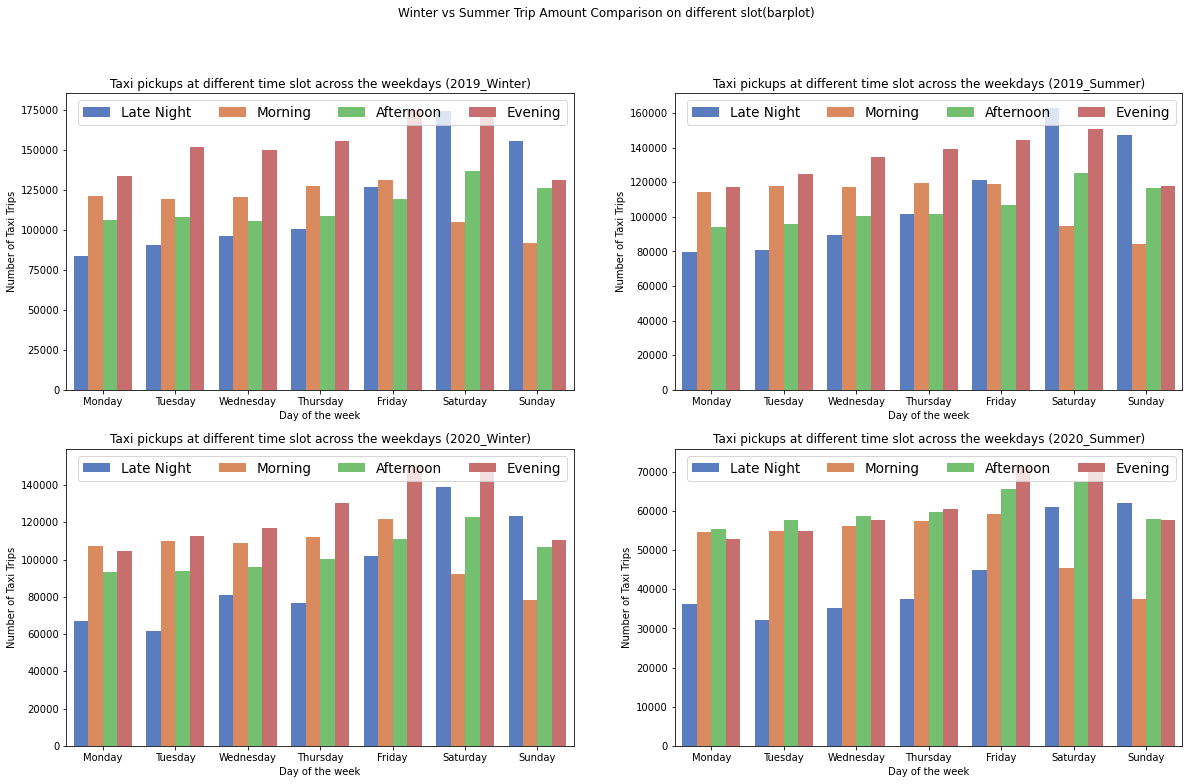

In [98]:
#Winter vs Summer Trip Amount Comparison on different slot(barplot)
wkOrder = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
timeSlotOrder = ['Late Night', 'Morning', 'Afternoon', 'Evening']
#fig, ax = plt.subplots(figsize=(7,4))
fig, ax_arr = plt.subplots(2,2, figsize=(20,12))
sns.barplot(x=agg_2019_winter.PU_Weekday, y=agg_2019_winter.avg_trips, hue=agg_2019_winter.time_desc,\
            order =wkOrder ,hue_order = timeSlotOrder,ax=ax_arr[0][0], palette = 'muted')
ax_arr[0][0].set_ylabel('Number of Taxi Trips')
ax_arr[0][0].set_xlabel('Day of the week')
ax_arr[0][0].set_title('Taxi pickups at different time slot across the weekdays (2019_Winter)')
ax_arr[0][0].legend(loc=1, ncol=4, prop={'size': 13.5})

sns.barplot(x=agg_2019_summer.PU_Weekday, y=agg_2019_summer.avg_trips, hue=agg_2019_summer.time_desc,\
            order =wkOrder ,hue_order = timeSlotOrder,ax=ax_arr[0][1], palette = 'muted')
ax_arr[0][1].set_ylabel('Number of Taxi Trips')
ax_arr[0][1].set_xlabel('Day of the week')
ax_arr[0][1].set_title('Taxi pickups at different time slot across the weekdays (2019_Summer)')
ax_arr[0][1].legend(loc=1, ncol=4, prop={'size': 13.5})

sns.barplot(x=agg_2020_winter.PU_Weekday, y=agg_2020_winter.avg_trips, hue=agg_2020_winter.time_desc,\
            order =wkOrder ,hue_order = timeSlotOrder,ax=ax_arr[1][0], palette = 'muted')
ax_arr[1][0].set_ylabel('Number of Taxi Trips')
ax_arr[1][0].set_xlabel('Day of the week')
ax_arr[1][0].set_title('Taxi pickups at different time slot across the weekdays (2020_Winter)')
ax_arr[1][0].legend(loc=1, ncol=4, prop={'size': 13.5})

sns.barplot(x=agg_2020_summer.PU_Weekday, y=agg_2020_summer.avg_trips, hue=agg_2020_summer.time_desc,\
            order =wkOrder ,hue_order = timeSlotOrder,ax=ax_arr[1][1], palette = 'muted')
ax_arr[1][1].set_ylabel('Number of Taxi Trips')
ax_arr[1][1].set_xlabel('Day of the week')
ax_arr[1][1].set_title('Taxi pickups at different time slot across the weekdays (2020_Summer)')
ax_arr[1][1].legend(loc=1, ncol=4, prop={'size': 13.5})
plt.ticklabel_format(style='plain', axis='y')
fig.suptitle('Winter vs Summer Trip Amount Comparison on different slot(barplot)')
plt.show()

### 1.2 Average Ridership between different time and DOW on different season(heatmap)

In [99]:
%time Uber_aggby_count = Uber_data.groupby(['PU_year','season','PU_Weekday','PU_Date','PU_Time']).count()[['PULocationID']].compute()
Uber_aggby_count.reset_index(inplace=True)

CPU times: user 7min 52s, sys: 1min 57s, total: 9min 49s
Wall time: 4min 53s


In [100]:
%time Uber_aggby_avg = Uber_aggby_count.groupby(['PU_year','season','PU_Weekday','PU_Time']).mean()[['PULocationID']]
Uber_aggby_avg.reset_index(inplace=True)

CPU times: user 8.44 ms, sys: 2.27 ms, total: 10.7 ms
Wall time: 9.38 ms


In [102]:
Uber_aggby_avg.rename(columns={'PULocationID':'avg_trips'},inplace=True)
Uber_aggby_avg['avg_trips']=Uber_aggby_avg['avg_trips'].astype('int64')

In [103]:
agg_2019_winter= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2019)&(Uber_aggby_avg['season']=='Winter')]
agg_2019_summer= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2019)&(Uber_aggby_avg['season']=='Summer')]
agg_2020_winter= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2020)&(Uber_aggby_avg['season']=='Winter')]
agg_2020_summer= Uber_aggby_avg.loc[(Uber_aggby_avg['PU_year']==2020)&(Uber_aggby_avg['season']=='Summer')]

In [130]:
pv_table_2019_winter = pd.pivot_table(agg_2019_winter, values='avg_trips',index=['PU_Time'],columns=['PU_Weekday'], aggfunc=np.sum, fill_value=0)
pv_table_2019_summer = pd.pivot_table(agg_2019_summer, values='avg_trips',index=['PU_Time'],columns=['PU_Weekday'], aggfunc=np.sum, fill_value=0)
pv_table_2020_winter = pd.pivot_table(agg_2020_winter, values='avg_trips',index=['PU_Time'],columns=['PU_Weekday'], aggfunc=np.sum, fill_value=0)
pv_table_2020_summer = pd.pivot_table(agg_2020_summer, values='avg_trips',index=['PU_Time'],columns=['PU_Weekday'], aggfunc=np.sum, fill_value=0)

In [131]:
pv_table_2019_winter = pv_table_2019_winter[[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].sort_values(by='PU_Time',ascending=False)
pv_table_2019_summer = pv_table_2019_summer[[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].sort_values(by='PU_Time',ascending=False)
pv_table_2020_winter = pv_table_2020_winter[[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].sort_values(by='PU_Time',ascending=False)
pv_table_2020_summer = pv_table_2020_summer[[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].sort_values(by='PU_Time',ascending=False)

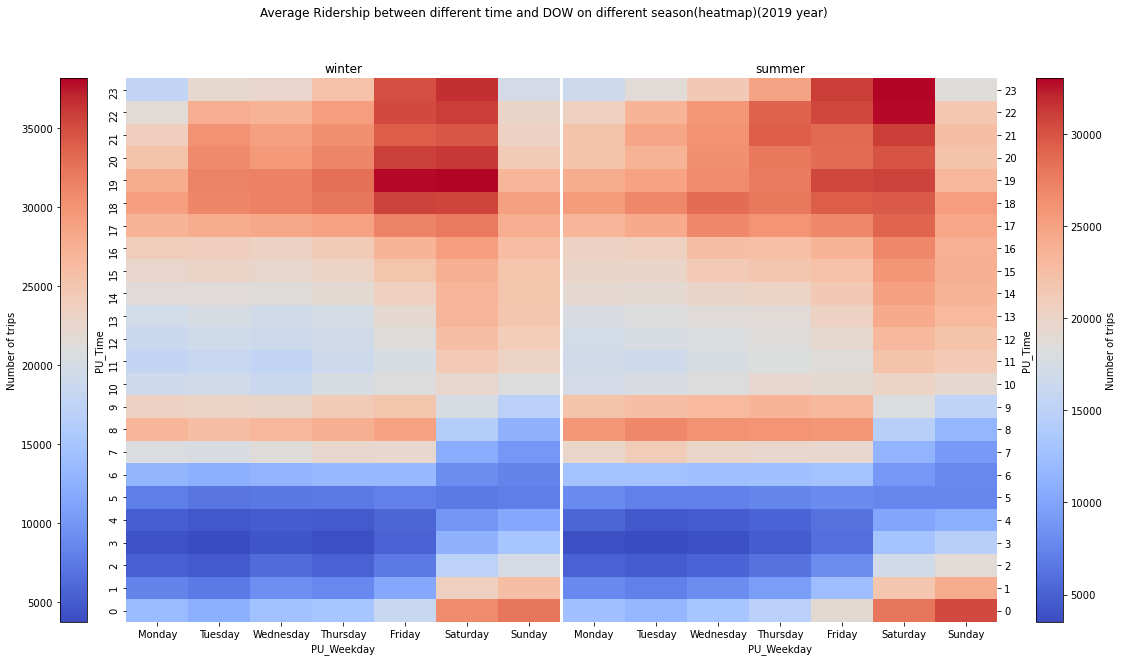

In [132]:
fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.005)

day_hour_winter = sns.heatmap(pv_table_2019_winter, ax=ax, cmap="coolwarm", cbar=False)
fig.colorbar(ax.collections[0], label='Number of trips', ax=ax,location="left", use_gridspec=False, pad=0.07)

day_hour_summer = sns.heatmap(pv_table_2019_summer, ax=ax2, cmap="coolwarm", cbar=False)
fig.colorbar(ax2.collections[0], label='Number of trips', ax=ax2,location="right", use_gridspec=False, pad=0.07)
ax.set_title('winter')
ax2.set_title('summer')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
fig.suptitle('Average Ridership between different time and DOW on different season(heatmap)(2019 year)')
plt.show()

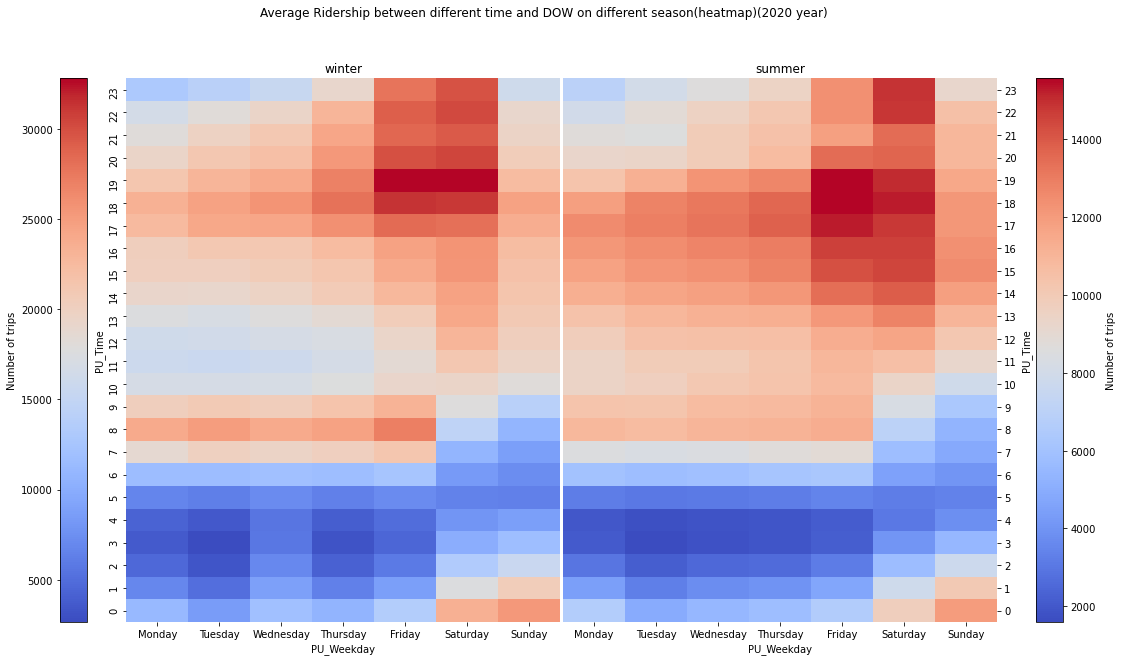

In [133]:
fig, (ax,ax2) = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.005)

day_hour_winter = sns.heatmap(pv_table_2020_winter, ax=ax, cmap="coolwarm", cbar=False)
fig.colorbar(ax.collections[0], label='Number of trips', ax=ax,location="left", use_gridspec=False, pad=0.07)

day_hour_summer = sns.heatmap(pv_table_2020_summer, ax=ax2, cmap="coolwarm", cbar=False)
fig.colorbar(ax2.collections[0], label='Number of trips', ax=ax2,location="right", use_gridspec=False, pad=0.07)
ax.set_title('winter')
ax2.set_title('summer')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
fig.suptitle('Average Ridership between different time and DOW on different season(heatmap)(2020 year)')
plt.show()

### 2.NYC Weather Data Processing

In [6]:
USA_weather = pd.read_csv('nyc_weather_data.csv',usecols=['STATION','NAME','DATE','AWND','PRCP','SNOW','SNWD','TMAX','TMIN'])
USA_weather.head()

,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN
0,USC00280907,"BOONTON 1 SE, NJ US",2018-01-01,NaN,0.00,0.0,0.0,13.0,4.0
1,USC00280907,"BOONTON 1 SE, NJ US",2018-01-02,NaN,0.00,0.0,0.0,17.0,3.0
2,USC00280907,"BOONTON 1 SE, NJ US",2018-01-03,NaN,0.00,0.0,0.0,24.0,7.0
3,USC00280907,"BOONTON 1 SE, NJ US",2018-01-04,NaN,0.00,0.0,0.0,27.0,5.0
4,USC00280907,"BOONTON 1 SE, NJ US",2018-01-05,NaN,0.56,5.0,5.0,24.0,7.0


In [7]:
USA_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90378 entries, 0 to 90377
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  90378 non-null  object 
 1   NAME     90378 non-null  object 
 2   DATE     90378 non-null  object 
 3   AWND     8563 non-null   float64
 4   PRCP     88797 non-null  float64
 5   SNOW     43706 non-null  float64
 6   SNWD     20754 non-null  float64
 7   TMAX     14898 non-null  float64
 8   TMIN     14919 non-null  float64
dtypes: float64(6), object(3)
memory usage: 6.2+ MB


In [8]:
#compare the weather condition among central park, JFK airport, EWR airport and LGA airport
#Time period:from 2018 year to 2020 year
location_list = ['USW00094728','USW00014732','USW00014734','USW00094789']
USA_weather['DATE'] = pd.to_datetime(USA_weather['DATE'])
NYC_weather = USA_weather.loc[USA_weather['STATION'].isin(location_list)]
NYC_weather = NYC_weather.loc[(NYC_weather['DATE']>='2018-01-01') & (NYC_weather['DATE']<='2020-12-31')]
NYC_weather['location_name'] = NYC_weather['NAME'].apply(lambda x: x.split(',')[0])
NYC_weather['TMAX'],NYC_weather['TMIN'] = NYC_weather['TMAX']-32,NYC_weather['TMIN']-32
NYC_weather['TAVG'] = (NYC_weather['TMAX']+NYC_weather['TMIN'])/2

In [13]:
NYC_weather.location_name.unique()

(731, 8)

In [9]:
NYC_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4384 entries, 4047 to 85815
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   STATION        4384 non-null   object        
 1   NAME           4384 non-null   object        
 2   DATE           4384 non-null   datetime64[ns]
 3   AWND           4193 non-null   float64       
 4   PRCP           4384 non-null   float64       
 5   SNOW           4384 non-null   float64       
 6   SNWD           4384 non-null   float64       
 7   TMAX           4384 non-null   float64       
 8   TMIN           4384 non-null   float64       
 9   location_name  4384 non-null   object        
 10  TAVG           4384 non-null   float64       
dtypes: datetime64[ns](1), float64(7), object(3)
memory usage: 411.0+ KB


Text(0.5, 1.0, 'NY CITY CENTRAL PARK')

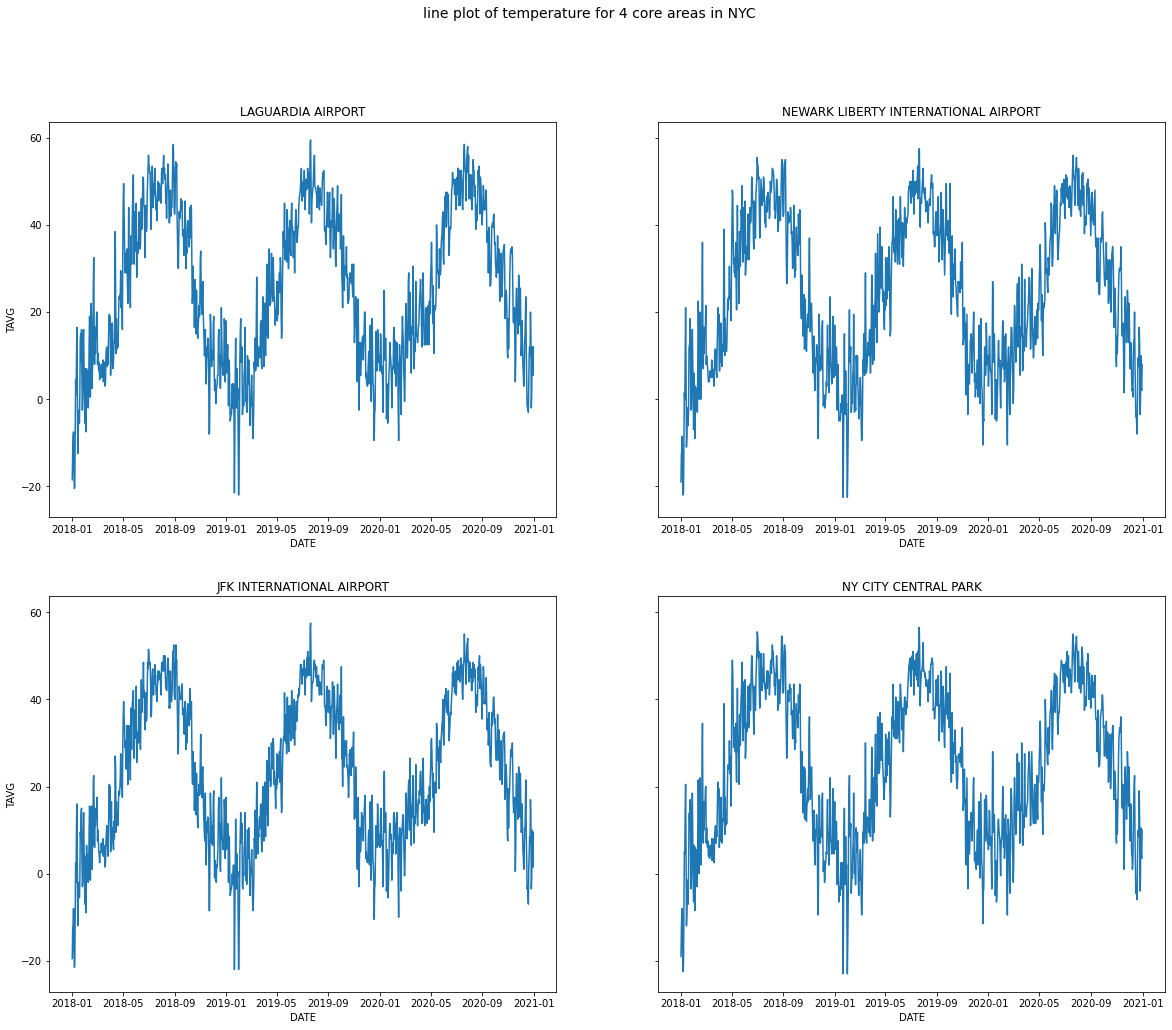

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(20,16), sharey=True)
fig.suptitle('line plot of temperature for 4 core areas in NYC',fontsize=14)
sns.lineplot(ax=axes[0][0],x='DATE',y='TAVG', data=NYC_weather[NYC_weather['location_name']=='LAGUARDIA AIRPORT'])
axes[0][0].set_title('LAGUARDIA AIRPORT')
sns.lineplot(ax=axes[0][1],x='DATE',y='TAVG', data=NYC_weather[NYC_weather['location_name']=='NEWARK LIBERTY INTERNATIONAL AIRPORT'])
axes[0][1].set_title('NEWARK LIBERTY INTERNATIONAL AIRPORT')
sns.lineplot(ax=axes[1][0],x='DATE',y='TAVG', data=NYC_weather[NYC_weather['location_name']=='JFK INTERNATIONAL AIRPORT'])
axes[1][0].set_title('JFK INTERNATIONAL AIRPORT')
sns.lineplot(ax=axes[1][1],x='DATE',y='TAVG', data=NYC_weather[NYC_weather['location_name']=='NY CITY CENTRAL PARK'])
axes[1][1].set_title('NY CITY CENTRAL PARK')

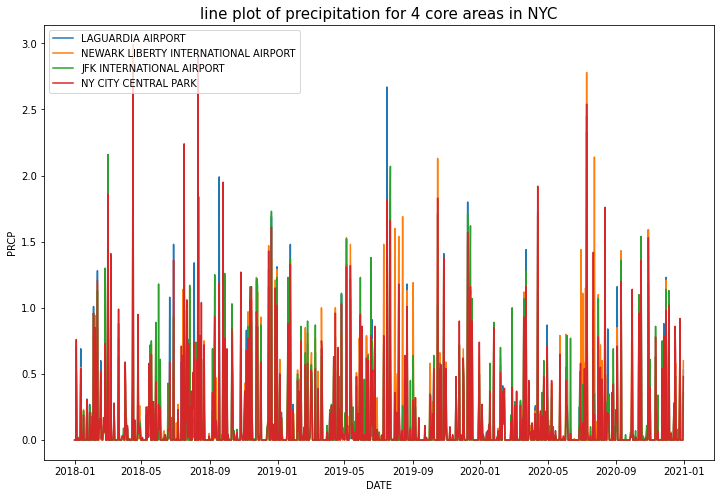

In [11]:
matplotlib.rcParams['figure.figsize'] = [12, 8]
sns.lineplot(x='DATE',y='PRCP', data=NYC_weather, hue='location_name')
plt.legend(loc='upper left')
plt.title('line plot of precipitation for 4 core areas in NYC', fontsize = 15)
plt.show()

### 3. merge ridership data with weather

In [16]:
uberDailyRidershipCnt = pd.read_csv('Uber_dailyRidership_count_18-20.csv')
uberDailyRidershipCnt = uberDailyRidershipCnt.groupby(['PU_Date','PU_Year','season']).sum()[['PUlocationID']]
uberDailyRidershipCnt.reset_index(inplace=True)
uberDailyRidershipCnt.rename(columns={'PUlocationID':'PU_count'},inplace=True)
uberDailyRidershipCnt['PU_Date'] = pd.to_datetime(uberDailyRidershipCnt['PU_Date'])
uberDailyRidershipCnt.head()

,PU_Date,PU_Year,season,PU_count
0,2018-01-01,2018,Winter,434939
1,2018-01-02,2018,Winter,309806
2,2018-01-03,2018,Winter,325029
3,2018-01-04,2018,Winter,225376
4,2018-01-05,2018,Winter,419043


In [17]:
uberRidershipVsWeather = pd.merge(uberDailyRidershipCnt, NYC_weather.loc[NYC_weather['STATION']=='USW00094728'], left_on='PU_Date', right_on='DATE',how='left').drop('DATE',axis=1)

In [19]:
uberRidershipVsWeather.head()

,PU_Date,PU_Year,season,PU_count,STATION,NAME,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,location_name,TAVG
0,2018-01-01,2018,Winter,434939,USW00094728,"NY CITY CENTRAL PARK, NY US",7.83,0.00,0.0,0.0,-13.0,-25.0,NY CITY CENTRAL PARK,-19.0
1,2018-01-02,2018,Winter,309806,USW00094728,"NY CITY CENTRAL PARK, NY US",8.05,0.00,0.0,0.0,-6.0,-19.0,NY CITY CENTRAL PARK,-12.5
2,2018-01-03,2018,Winter,325029,USW00094728,"NY CITY CENTRAL PARK, NY US",3.13,0.00,0.0,0.0,-2.0,-16.0,NY CITY CENTRAL PARK,-9.0
3,2018-01-04,2018,Winter,225376,USW00094728,"NY CITY CENTRAL PARK, NY US",12.53,0.76,9.8,1.2,-3.0,-13.0,NY CITY CENTRAL PARK,-8.0
4,2018-01-05,2018,Winter,419043,USW00094728,"NY CITY CENTRAL PARK, NY US",12.97,0.00,0.0,7.1,-13.0,-23.0,NY CITY CENTRAL PARK,-18.0


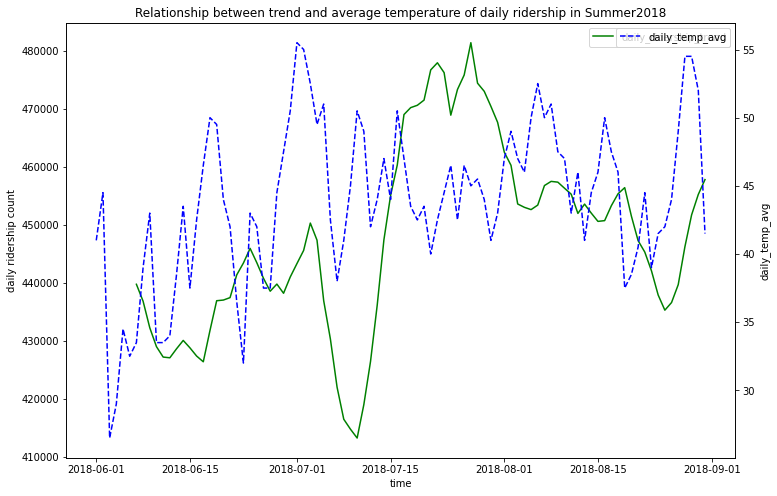

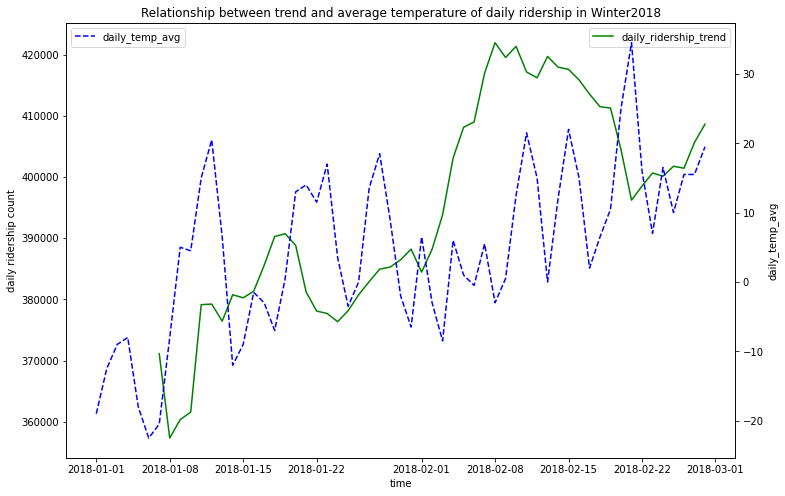

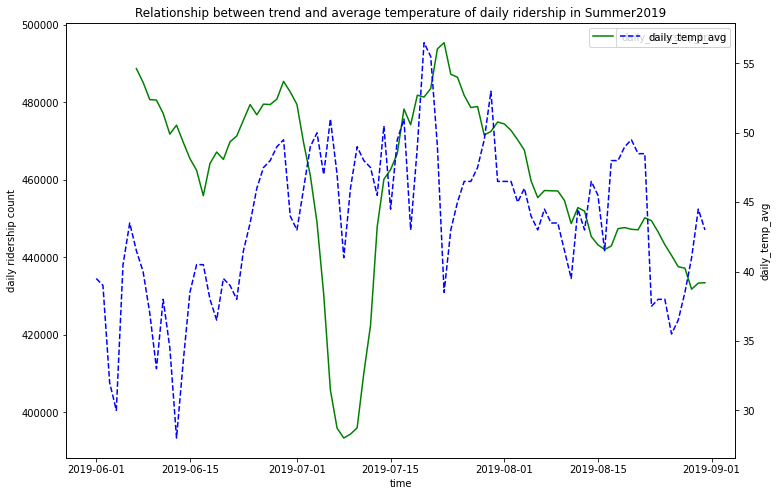

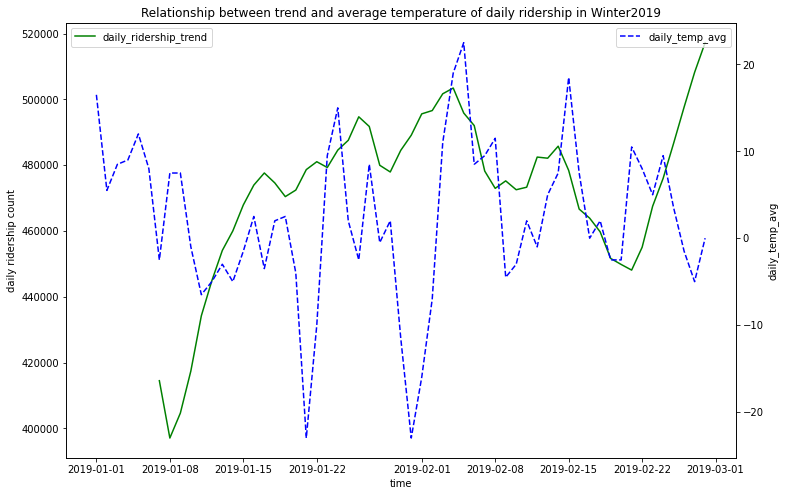

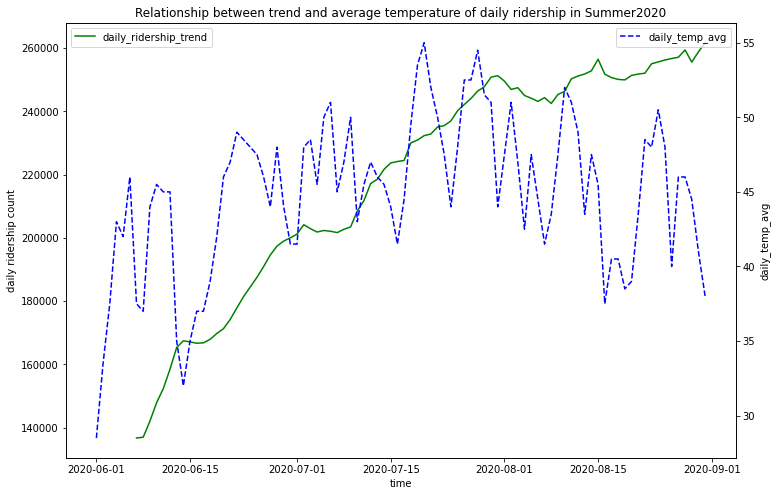

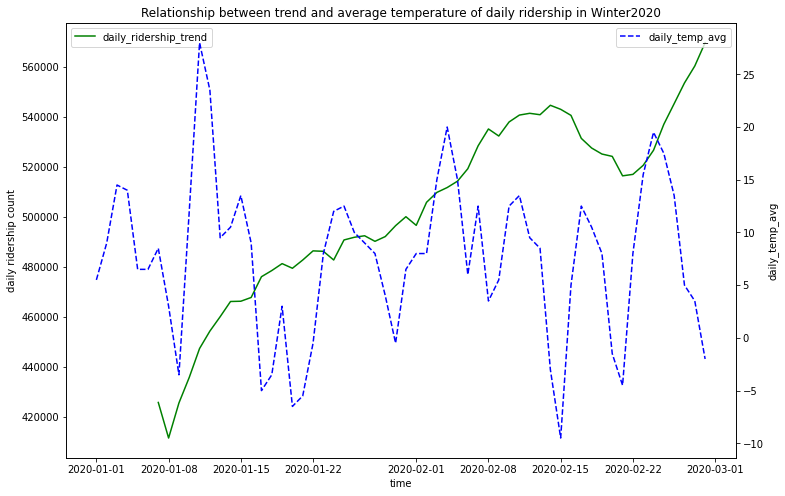

In [51]:
for year in [2018,2019,2020]:
    for se in ['Summer','Winter']:
        if se =='Winter':
            dfTemp = uberRidershipVsWeather[(uberRidershipVsWeather['PU_Date'].dt.month<=2)&(uberRidershipVsWeather['PU_Year']==year)]
            fig,ax1 = plt.subplots()
            ax2 = ax1.twinx()
            ax1.plot(dfTemp.PU_Date,dfTemp.PU_count.rolling(window = 7).mean(), color = 'green',label='daily_ridership_trend')
            ax2.plot(dfTemp.PU_Date,dfTemp.TAVG,label='daily_temp_avg',color = 'blue',linestyle='--')
            ax1.set_title('Relationship between trend and average temperature of daily ridership in '+se+''+str(year))
            ax1.set_xlabel('time')
            ax1.set_ylabel('daily ridership count')
            ax2.set_ylabel('daily_temp_avg')
            ax1.legend()
            ax2.legend()
        else:
            dfTemp = uberRidershipVsWeather[(uberRidershipVsWeather['season']==se)&(uberRidershipVsWeather['PU_Year']==year)]
            fig,ax1 = plt.subplots()
            ax2 = ax1.twinx()

            ax1.plot(dfTemp.PU_Date,dfTemp.PU_count.rolling(window = 7).mean(), color = 'green',label='daily_ridership_trend')
            ax2.plot(dfTemp.PU_Date,dfTemp.TAVG,label='daily_temp_avg',color = 'blue',linestyle='--')

            ax1.set_title('Relationship between trend and average temperature of daily ridership in '+se+''+str(year))
            ax1.set_xlabel('time')
            ax1.set_ylabel('daily ridership count')
            ax2.set_ylabel('daily_temp_avg')
            ax1.legend()
            ax2.legend()

In [53]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
lm1 = smf.ols(formula='PU_count~PRCP', data = uberRidershipVsWeather).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:               PU_count   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.859
Date:                Mon, 02 May 2022   Prob (F-statistic):            0.00894
Time:                        00:40:48   Log-Likelihood:                -14466.
No. Observations:                1096   AIC:                         2.894e+04
Df Residuals:                    1094   BIC:                         2.895e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.014e+05   4305.462     93.228      0.0

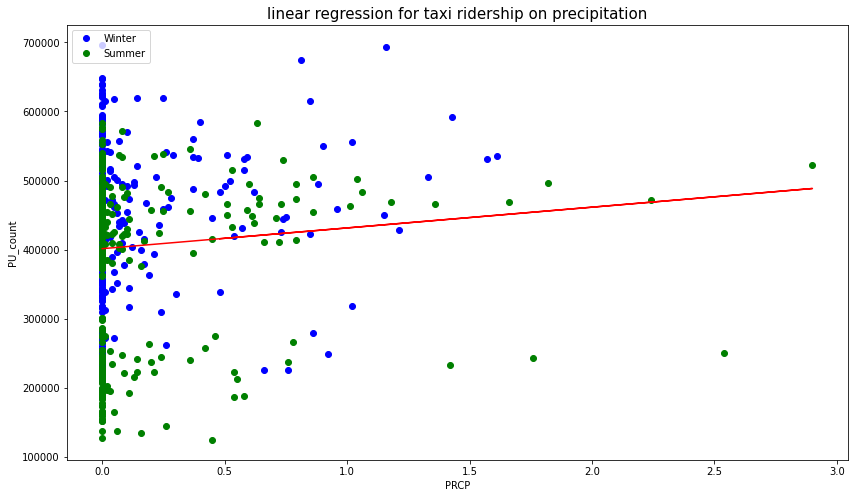

In [54]:
#Uber taxi ridership distribution by precipitation
plt.figure(figsize=(14,8))
plt.plot(uberRidershipVsWeather.loc[uberRidershipVsWeather['season']=='Winter']['PRCP'], uberRidershipVsWeather.loc[uberRidershipVsWeather['season']=='Winter']['PU_count'], 'o',color='blue',label='Winter')
plt.plot(uberRidershipVsWeather.loc[uberRidershipVsWeather['season']=='Summer']['PRCP'], uberRidershipVsWeather.loc[uberRidershipVsWeather['season']=='Summer']['PU_count'], 'o',color='green',label='Summer')
plt.legend(loc='upper left')
plt.title('linear regression for taxi ridership on precipitation', fontsize = 15)
plt.xlabel('PRCP')
plt.ylabel('PU_count')
plt.plot(uberRidershipVsWeather['PRCP'], lm1.predict(), '-r')

In [56]:
#Uber taxi ridership distribution by snowfall(inches)
lm2 = smf.ols(formula='PU_count~SNOW', data = uberRidershipVsWeather.loc[uberRidershipVsWeather['SNOW']>0]).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:               PU_count   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     7.372
Date:                Mon, 02 May 2022   Prob (F-statistic):             0.0114
Time:                        00:42:18   Log-Likelihood:                -372.36
No. Observations:                  29   AIC:                             748.7
Df Residuals:                      27   BIC:                             751.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.834e+05   2.37e+04     20.424      0.0

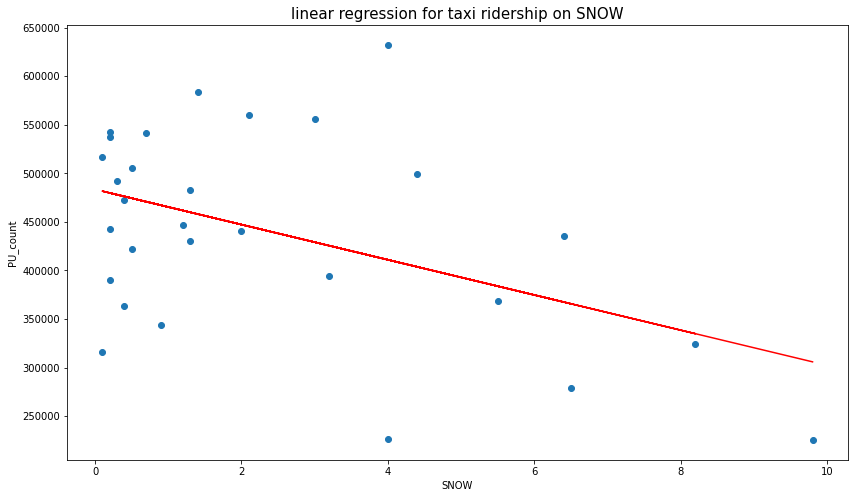

In [57]:
plt.figure(figsize=(14,8))
plt.plot(uberRidershipVsWeather.loc[uberRidershipVsWeather['SNOW']>0]['SNOW'], uberRidershipVsWeather.loc[uberRidershipVsWeather['SNOW']>0]['PU_count'], 'o')
plt.title('linear regression for taxi ridership on SNOW', fontsize = 15)
plt.xlabel('SNOW')
plt.ylabel('PU_count')
plt.plot(uberRidershipVsWeather.loc[uberRidershipVsWeather['SNOW']>0]['SNOW'], lm2.predict(), '-r')

In [58]:
#Uber taxi ridership distribution by windspeed(miles per hour)
taxi_weather_data_dropNaAWND = uberRidershipVsWeather.dropna(subset=['AWND'])
lm3 = smf.ols(formula='PU_count~AWND', data = taxi_weather_data_dropNaAWND).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:               PU_count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.076
Date:                Mon, 02 May 2022   Prob (F-statistic):              0.300
Time:                        00:42:53   Log-Likelihood:                -11943.
No. Observations:                 906   AIC:                         2.389e+04
Df Residuals:                     904   BIC:                         2.390e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.099e+05   9669.078     42.398      0.0

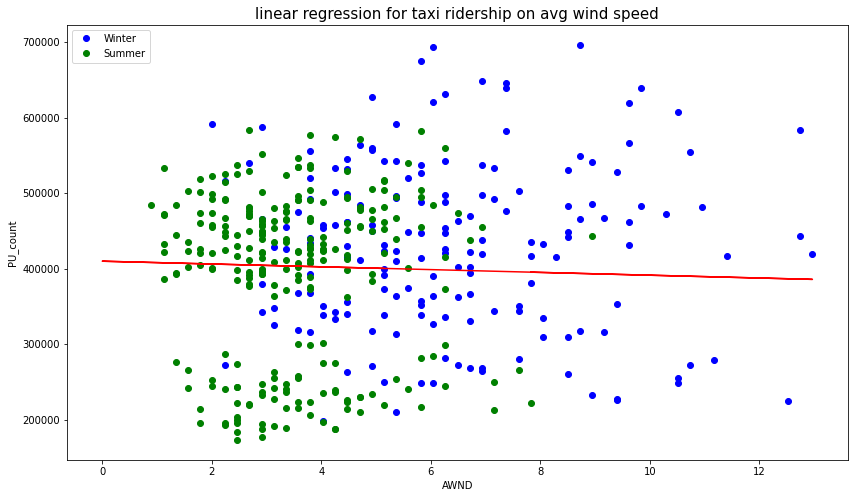

In [59]:
plt.figure(figsize=(14,8))
plt.plot(taxi_weather_data_dropNaAWND.loc[taxi_weather_data_dropNaAWND['season']=='Winter']['AWND'], taxi_weather_data_dropNaAWND.loc[taxi_weather_data_dropNaAWND['season']=='Winter']['PU_count'], 'o',color='blue',label='Winter')
plt.plot(taxi_weather_data_dropNaAWND.loc[taxi_weather_data_dropNaAWND['season']=='Summer']['AWND'], taxi_weather_data_dropNaAWND.loc[taxi_weather_data_dropNaAWND['season']=='Summer']['PU_count'], 'o',color='green',label='Summer')
plt.legend(loc='upper left')
plt.title('linear regression for taxi ridership on avg wind speed', fontsize = 15)
plt.xlabel('AWND')
plt.ylabel('PU_count')
plt.plot(taxi_weather_data_dropNaAWND['AWND'], lm3.predict(), '-r')

In [60]:
#Uber taxi ridership distribution by avg temperature(celsius degree)
lm4 = smf.ols(formula='PU_count~TAVG', data = uberRidershipVsWeather).fit()
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:               PU_count   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     42.99
Date:                Mon, 02 May 2022   Prob (F-statistic):           8.45e-11
Time:                        00:43:33   Log-Likelihood:                -14448.
No. Observations:                1096   AIC:                         2.890e+04
Df Residuals:                    1094   BIC:                         2.891e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.425e+05   6807.035     65.011      0.0

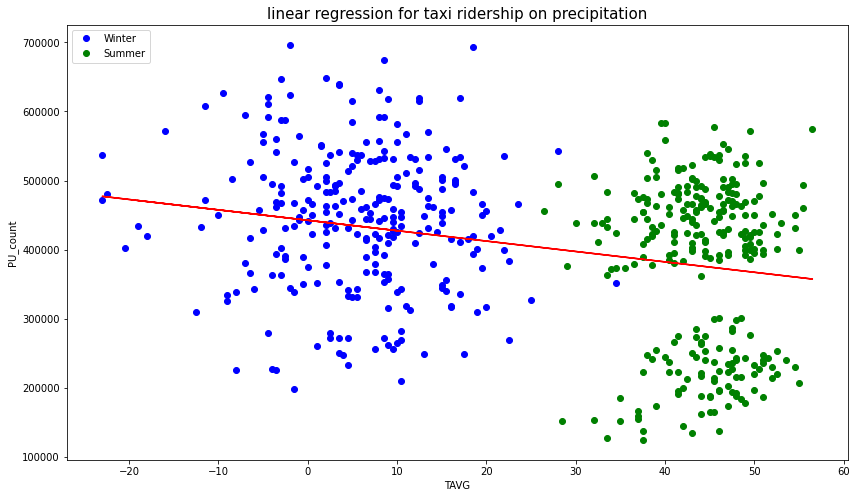

In [61]:
#Uber taxi ridership distribution by temperature
plt.figure(figsize=(14,8))
plt.plot(uberRidershipVsWeather.loc[uberRidershipVsWeather['season']=='Winter']['TAVG'], uberRidershipVsWeather.loc[uberRidershipVsWeather['season']=='Winter']['PU_count'], 'o',color='blue',label='Winter')
plt.plot(uberRidershipVsWeather.loc[uberRidershipVsWeather['season']=='Summer']['TAVG'], uberRidershipVsWeather.loc[uberRidershipVsWeather['season']=='Summer']['PU_count'], 'o',color='green',label='Summer')
plt.legend(loc='upper left')
plt.title('linear regression for taxi ridership on precipitation', fontsize = 15)
plt.xlabel('TAVG')
plt.ylabel('PU_count')
plt.plot(uberRidershipVsWeather['TAVG'], lm4.predict(), '-r')

In [13]:
###load yellow&green yearly data
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime

output_columns = ['lpep_pickup_datetime',
       'lpep_dropoff_datetime', 'trip_distance',
        'PULocationID', 'DOLocationID','fare_amount','tip_amount','improvement_surcharge', 'total_amount']


Yellow_2019 = dd.read_csv('green_tripdata_2020*.csv',dtype={'trip_distance':'float64',
        'PULocationID':'int64', 'DOLocationID':'int64','fare_amount':'float64','tip_amount':'float64','improvement_surcharge':'float64', 'total_amount':'float64'},usecols=output_columns)

Yellow_2019['lpep_pickup_datetime'] =dd.to_datetime(Yellow_2019['lpep_pickup_datetime'])
Yellow_2019['PU_Date'] = Yellow_2019['lpep_pickup_datetime'].dt.normalize()
Yellow_2019['PU_Month'] = Yellow_2019['lpep_pickup_datetime'].dt.month
Yellow_2019 = Yellow_2019.loc[(Yellow_2019['PU_Date']>=('2020-01-01')) &(Yellow_2019['PU_Date']<=('2020-12-31'))]

daily_avg = Yellow_2019.groupby(['PU_Date','PU_Month']).mean()[['trip_distance','fare_amount','tip_amount','improvement_surcharge', 'total_amount']].compute()
daily_avg.reset_index(inplace=True)
daily_avg.to_csv('Green_2020_daily.csv')

In [9]:
green = pd.read_csv('green_tripdata_2018-01.csv')
green.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793529 entries, 0 to 793528
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               793529 non-null  int64  
 1   lpep_pickup_datetime   793529 non-null  object 
 2   lpep_dropoff_datetime  793529 non-null  object 
 3   store_and_fwd_flag     793529 non-null  object 
 4   RatecodeID             793529 non-null  int64  
 5   PULocationID           793529 non-null  int64  
 6   DOLocationID           793529 non-null  int64  
 7   passenger_count        793529 non-null  int64  
 8   trip_distance          793529 non-null  float64
 9   fare_amount            793529 non-null  float64
 10  extra                  793529 non-null  float64
 11  mta_tax                793529 non-null  float64
 12  tip_amount             793529 non-null  float64
 13  tolls_amount           793529 non-null  float64
 14  ehail_fee              0 non-null   

In [17]:
yellow_201901.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
VendorID                 10000 non-null int64
tpep_pickup_datetime     10000 non-null object
tpep_dropoff_datetime    10000 non-null object
passenger_count          10000 non-null int64
trip_distance            10000 non-null float64
RatecodeID               10000 non-null int64
store_and_fwd_flag       10000 non-null object
PULocationID             10000 non-null int64
DOLocationID             10000 non-null int64
payment_type             10000 non-null int64
fare_amount              10000 non-null float64
extra                    10000 non-null float64
mta_tax                  10000 non-null float64
tip_amount               10000 non-null float64
tolls_amount             10000 non-null float64
improvement_surcharge    10000 non-null float64
total_amount             10000 non-null float64
congestion_surcharge     0 non-null float64
dtypes: float64(9), int64(6), object(3)
memory 

In [18]:
yellow_2019 = pd.read_csv('yellow_2019_*.csv',dtype={'passenger_count':'int64', 'trip_distance':'float64',
        'PULocationID':'int64', 'DOLocationID':'int64','fare_amount':'float64','tip_amount':'float64','improvement_surcharge':'float64', 'total_amount':'float64'},usecols= output_columns)
yellow_2019.to_csv('Yellow_2019_jony.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
VendorID                 10000 non-null int64
tpep_pickup_datetime     10000 non-null object
tpep_dropoff_datetime    10000 non-null object
passenger_count          10000 non-null int64
trip_distance            10000 non-null float64
RatecodeID               10000 non-null int64
store_and_fwd_flag       10000 non-null object
PULocationID             10000 non-null int64
DOLocationID             10000 non-null int64
payment_type             10000 non-null int64
fare_amount              10000 non-null float64
extra                    10000 non-null float64
mta_tax                  10000 non-null float64
tip_amount               10000 non-null float64
tolls_amount             10000 non-null float64
improvement_surcharge    10000 non-null float64
total_amount             10000 non-null float64
congestion_surcharge     10000 non-null float64
dtypes: float64(9), int64(6), object(3)
mem

In [34]:

yellow_2018['tpep_pickup_datetime'] =pd.to_datetime(yellow_2018['tpep_pickup_datetime'])
yellow_2018['PU_Date'] = yellow_2018['tpep_pickup_datetime'].dt.normalize()
yellow_2018['PU_Time'] = yellow_2018['tpep_pickup_datetime'].dt.hour
yellow_2018['PU_Month'] = yellow_2018['tpep_pickup_datetime'].dt.month
yellow_2018 = yellow_2018.loc[(yellow_2018['PU_Date']>='2018-01-01') &(yellow_2018['PU_Date']<='2018-12-31')]

%time yellow_2018_day_hour_avg = yellow_2018.groupby(['PU_Date','PU_Time','PU_Month']).mean()[['passenger_count','trip_distance',\
                                                                                              'fare_amount','tip_amount','improvement_surcharge', 'total_amount']]
yellow_2018_day_hour_avg.reset_index(inplace=True)

CPU times: user 20.1 s, sys: 11.5 s, total: 31.6 s
Wall time: 31.7 s


In [2]:
#process weather data
USA_weather = pd.read_csv('nyc_weather_data.csv',usecols=['STATION','NAME','DATE','AWND','PRCP','SNOW','SNWD','TMAX','TMIN'])
USA_weather['DATE'] = pd.to_datetime(USA_weather['DATE'])
NYC_weather = USA_weather.loc[USA_weather['STATION']=='USW00094728']
NYC_weather = NYC_weather.loc[(NYC_weather['DATE']>='2018-01-01') & (NYC_weather['DATE']<='2020-12-31')]
NYC_weather['TMAX'],NYC_weather['TMIN'] = (NYC_weather['TMAX']-32)/1.8,(NYC_weather['TMIN']-32)/1.8
NYC_weather['TAVG'] = (NYC_weather['TMAX']+NYC_weather['TMIN'])/2
#raining level: less than 0.1 inch:light rain;between 0.1 and 0.3 inche:moderate rainfall;greater than 0.3 inch:heavy rainfall
#snowdepth:whether or not
def raining_lvl(x):
    if x <=0.1 :
        return 'light'
    elif x>0.1 and x<=0.3:
        return 'moderate'
    else:
        return 'heavy' 
def temp_lvl(x):
    if x<=0:
        return 'cold'
    elif x>0 and x<=26:
        return 'comfortable'
    else: return 'hot'
    
NYC_weather['temp_level']  = NYC_weather['TAVG'].apply(temp_lvl)
NYC_weather['raining_level'] = NYC_weather['PRCP'].apply(raining_lvl)
NYC_weather['ifsnowdepth'] = NYC_weather['SNWD']>0

In [3]:
NYC_weather.head()

,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,TAVG,temp_level,raining_level,ifsnowdepth
84720,USW00094728,"NY CITY CENTRAL PARK, NY US",2018-01-01,7.83,0.00,0.0,0.0,-7.222222,-13.888889,-10.555556,cold,light,False
84721,USW00094728,"NY CITY CENTRAL PARK, NY US",2018-01-02,8.05,0.00,0.0,0.0,-3.333333,-10.555556,-6.944444,cold,light,False
84722,USW00094728,"NY CITY CENTRAL PARK, NY US",2018-01-03,3.13,0.00,0.0,0.0,-1.111111,-8.888889,-5.000000,cold,light,False
84723,USW00094728,"NY CITY CENTRAL PARK, NY US",2018-01-04,12.53,0.76,9.8,1.2,-1.666667,-7.222222,-4.444444,cold,heavy,True
84724,USW00094728,"NY CITY CENTRAL PARK, NY US",2018-01-05,12.97,0.00,0.0,7.1,-7.222222,-12.777778,-10.000000,cold,light,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
Unnamed: 0               8760 non-null int64
PU_Date                  8760 non-null object
PU_Time                  8760 non-null int64
PU_Month                 8760 non-null int64
passenger_count          8760 non-null float64
trip_distance            8760 non-null float64
fare_amount              8760 non-null float64
tip_amount               8760 non-null float64
improvement_surcharge    8760 non-null float64
total_amount             8760 non-null float64
dtypes: float64(6), int64(3), object(1)
memory usage: 684.5+ KB


In [8]:
#merge weather information with yellow taxi infomation
yellow_2018_day_hour_avg = pd.read_csv('yellow_2018_day_hour_avg.csv')
yellow_2018_day_hour_avg['PU_Date'] = pd.to_datetime(yellow_2018_day_hour_avg['PU_Date'])
YellowOrderVsWeather = pd.merge(yellow_2018_day_hour_avg, NYC_weather, left_on='PU_Date', right_on='DATE',how='left').drop('DATE',axis=1)
def season_tag(x):
    if x in (1,2,12):
        return 'Winter'
    elif x in range(3,6):
        return 'Spring'
    elif x in range(6,9):
        return 'Summer'
    else:
        return 'Autumn'
YellowOrderVsWeather['season'] = YellowOrderVsWeather['PU_Month'].apply(season_tag) 

YellowOrderVsWeather.head()

,Unnamed: 0,PU_Date,PU_Time,PU_Month,passenger_count,trip_distance,fare_amount,tip_amount,improvement_surcharge,total_amount,...,PRCP,SNOW,SNWD,TMAX,TMIN,TAVG,temp_level,raining_level,ifsnowdepth,season
0,73,2018-01-01,0,1,1.739580,2.754618,12.621758,1.617691,0.299526,15.646119,...,0.0,0.0,0.0,-7.222222,-13.888889,-10.555556,cold,light,False,Winter
1,74,2018-01-01,1,1,1.726521,2.957461,12.864467,1.727244,0.299605,16.027503,...,0.0,0.0,0.0,-7.222222,-13.888889,-10.555556,cold,light,False,Winter
2,75,2018-01-01,2,1,1.688666,3.083759,12.988859,1.723989,0.299366,16.153183,...,0.0,0.0,0.0,-7.222222,-13.888889,-10.555556,cold,light,False,Winter
3,76,2018-01-01,3,1,1.684482,3.167346,12.950800,1.631373,0.299120,16.007900,...,0.0,0.0,0.0,-7.222222,-13.888889,-10.555556,cold,light,False,Winter
4,77,2018-01-01,4,1,1.698602,3.562889,13.898338,1.520717,0.298969,16.916547,...,0.0,0.0,0.0,-7.222222,-13.888889,-10.555556,cold,light,False,Winter


In [9]:
%time yellow_2018_season_hour_avg = YellowOrderVsWeather.groupby(['season','PU_Time']).mean()[['passenger_count','trip_distance',\
                                                                                              'fare_amount','tip_amount','improvement_surcharge', 'total_amount']]
yellow_2018_season_hour_avg.reset_index(inplace=True)

CPU times: user 18 ms, sys: 2 ms, total: 20 ms
Wall time: 15.5 ms


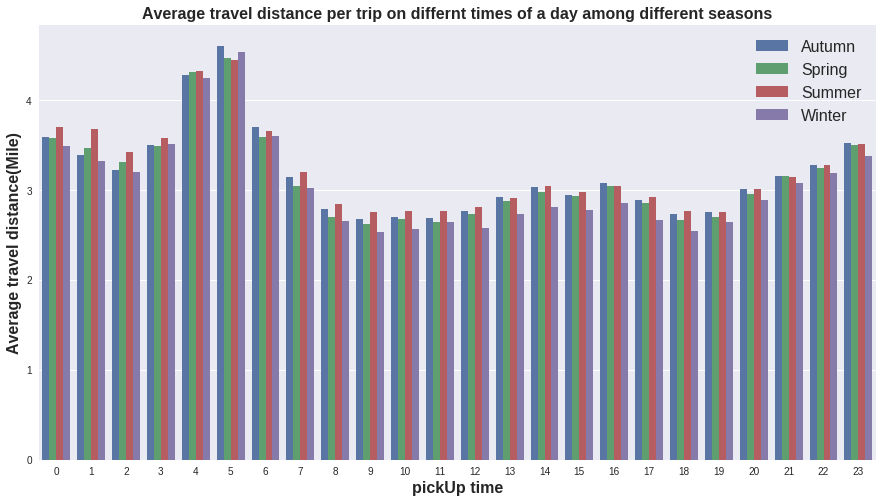

In [10]:
# 2018 yellow taxi average trip distance VS pickup time
#yellow_2018_day_hour_avg.to_csv('yellow_2018_day_hour_avg.csv')
import warnings
from matplotlib import pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
plt.figure(figsize=(15,8))
ax = sns.barplot(x='PU_Time',y='trip_distance',hue='season',data =yellow_2018_season_hour_avg)
ax.axes.set_title('Average travel distance per trip on differnt times of a day among different seasons',fontsize=16,weight='bold')
ax.set_xlabel('pickUp time',fontsize=16,weight='bold')
ax.set_ylabel('Average travel distance(Mile)',fontsize=16,weight='bold')
ax.legend(fontsize=16)
plt.show()


In [15]:
yellow_2018_season_hour_avg.shape

(96, 8)

Text(0,0.5,'trip_distance')

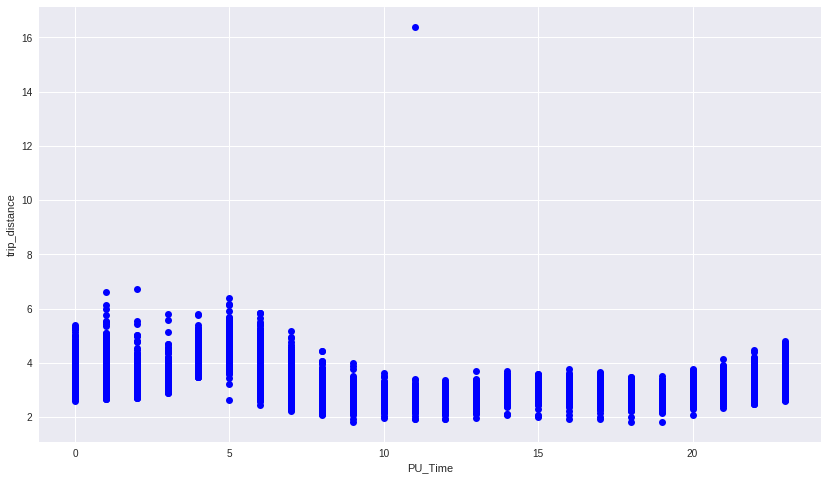

In [16]:
plt.figure(figsize=(14,8))
plt.plot(YellowOrderVsWeather['PU_Time'], YellowOrderVsWeather['trip_distance'], 'o',color='blue',label='season')
plt.xlabel('PU_Time')
plt.ylabel('trip_distance')

## 4-5pm is the shift time of NYC taxi drivers. It is supposed that the reason for the longer average driving distance is that the driver needs to drive the vehicle to the designated return area.

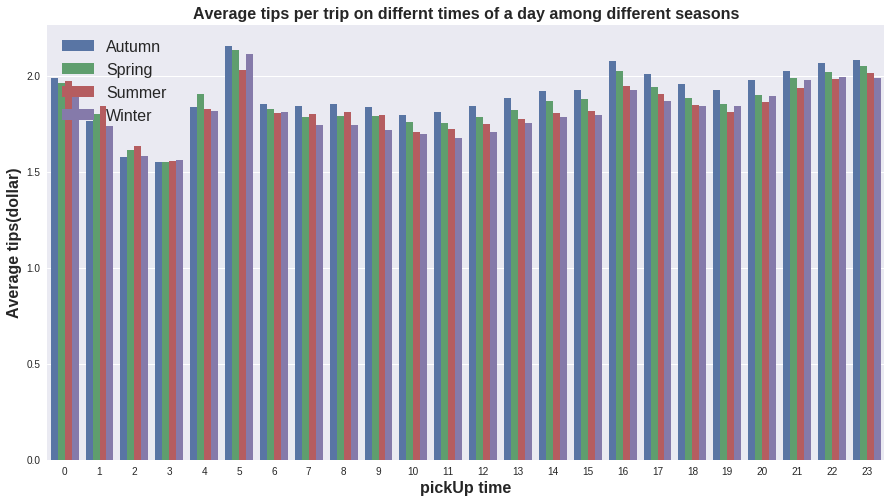

In [67]:
# tip_amount

plt.figure(figsize=(15,8))
ax = sns.barplot(x='PU_Time',y='tip_amount',hue='season',data =yellow_2018_season_hour_avg)
ax.axes.set_title('Average tips per trip on differnt times of a day among different seasons',fontsize=16,weight='bold')
ax.set_xlabel('pickUp time',fontsize=16,weight='bold')
ax.set_ylabel('Average tips(dollar)',fontsize=16,weight='bold')
ax.legend(fontsize=16)
plt.show()

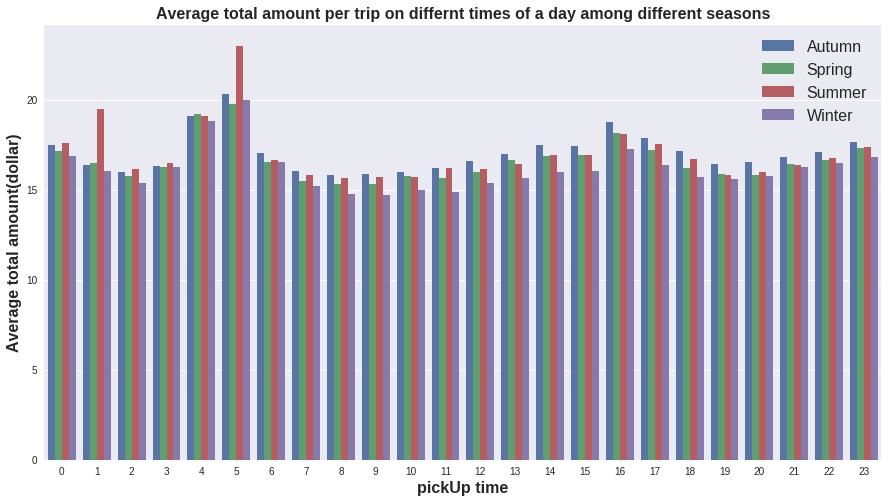

In [68]:
# total_amount

plt.figure(figsize=(15,8))
ax = sns.barplot(x='PU_Time',y='total_amount',hue='season',data =yellow_2018_season_hour_avg)
ax.axes.set_title('Average total amount per trip on differnt times of a day among different seasons',fontsize=16,weight='bold')
ax.set_xlabel('pickUp time',fontsize=16,weight='bold')
ax.set_ylabel('Average total amount(dollar)',fontsize=16,weight='bold')
ax.legend(fontsize=16)
plt.show()

In [ ]:


#yellow_2018_seaon_hour_avg = YellowOrderVsWeather.groupby(['season','PU_Time']).avg()[['passenger_count', 'trip_distance',
#        'fare_amount','tip_amount','improvement_surcharge', 'total_amount']]
#yellow_2018_seaon_hour_avg.reset_index(inplace=True)

#2018 year

import seaborn as sns
sns.barplot(x='PU_Time',y='trip_distance',hue='season',data =YellowOrderVsWeather ).set(title='avg tralve distance on time of a day between different season')


# fare_amount
# tip_amount
# total_amount

#2019 year
#2020 year

#分三年统计，不同季节(summer vs winter)下的每小时平均订单距离，平均车费，平均小费以及平均总费用
#1.按每天每小时平均指标，然后和天气数据根据天关联，根据天打上season标签，再在一个season下每小时平均绘图

# Step1: Correlation analysis between trip distance& taxi fare and weather factors

In [ ]:
yellow_2018 = pd.read_csv('Yellow_2018_daily.csv')
yellow_2018['PU_Date'] = pd.to_datetime(yellow_2018['PU_Date'])
Yellow_2018_Vs_Weather = pd.merge(yellow_2018, NYC_weather, left_on='PU_Date', right_on='DATE',how='left').drop('DATE',axis=1)

In [ ]:
green_2018 = pd.read_csv('Green_2018_daily.csv')
green_2018['PU_Date'] = pd.to_datetime(green_2018['PU_Date'])
green_2018_Vs_Weather = pd.merge(green_2018, NYC_weather, left_on='PU_Date', right_on='DATE',how='left').drop('DATE',axis=1)

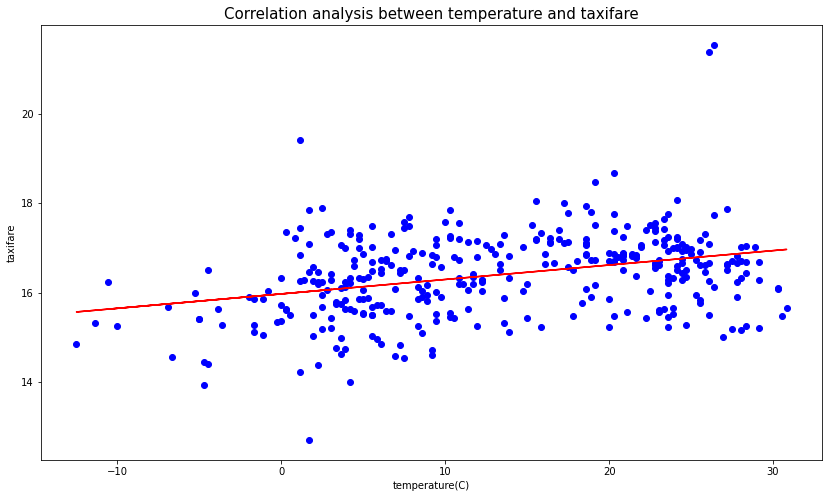

In [90]:
#Correlation analysis
#year:2018
#data source: yellow taxi
import statsmodels.formula.api as smf
import statsmodels.api as sm
lm1 = smf.ols(formula='total_amount~TAVG', data = Yellow_2018_Vs_Weather).fit()
#print(lm1.summary())
plt.figure(figsize=(14,8))
plt.plot(Yellow_2018_Vs_Weather['TAVG'], Yellow_2018_Vs_Weather['total_amount'], 'o',color='blue')
plt.title('Correlation analysis between temperature and taxifare', fontsize = 15)
plt.xlabel('temperature(C)')
plt.ylabel('taxifare')
plt.plot(Yellow_2018_Vs_Weather['TAVG'], lm1.predict(), '-r')

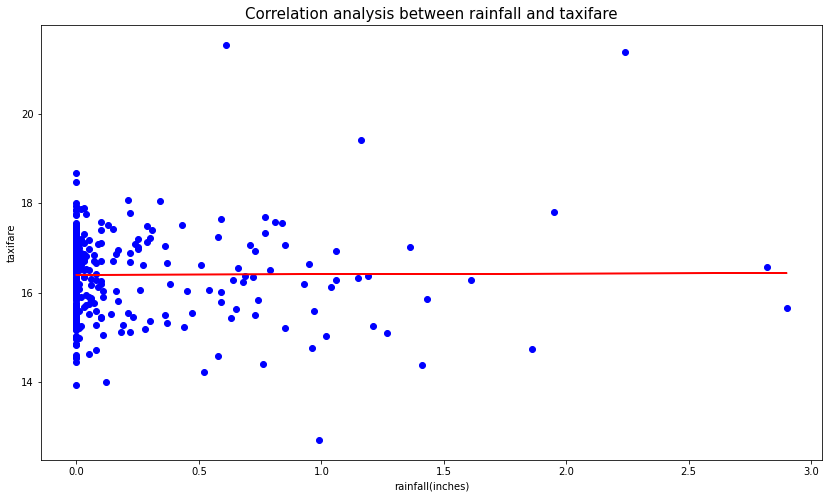

In [91]:
lm2 = smf.ols(formula='total_amount~PRCP', data = Yellow_2018_Vs_Weather).fit()
#print(lm1.summary())
plt.figure(figsize=(14,8))
plt.plot(Yellow_2018_Vs_Weather['PRCP'], Yellow_2018_Vs_Weather['total_amount'], 'o',color='blue')
plt.title('Correlation analysis between rainfall and taxifare', fontsize = 15)
plt.xlabel('rainfall(inches)')
plt.ylabel('taxifare')
plt.plot(Yellow_2018_Vs_Weather['PRCP'], lm2.predict(), '-r')

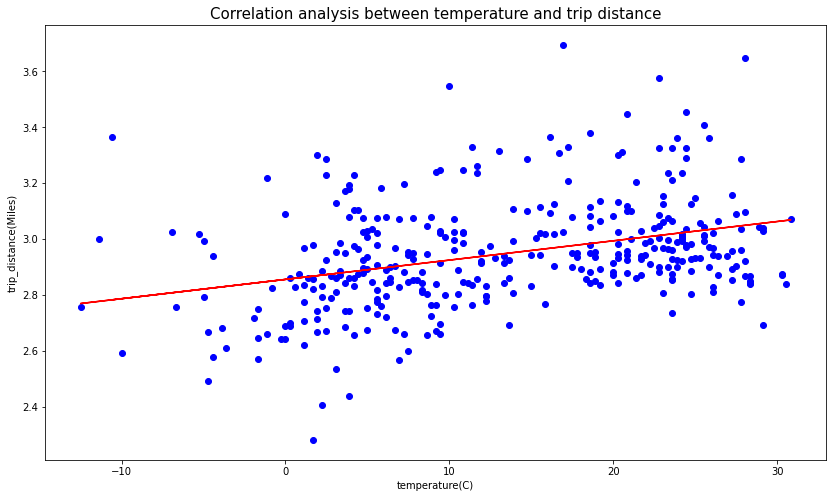

In [94]:
lm2 = smf.ols(formula='trip_distance~TAVG', data = Yellow_2018_Vs_Weather).fit()
#print(lm1.summary())
plt.figure(figsize=(14,8))
plt.plot(Yellow_2018_Vs_Weather['TAVG'], Yellow_2018_Vs_Weather['trip_distance'], 'o',color='blue')
plt.title('Correlation analysis between temperature and trip distance', fontsize = 15)
plt.xlabel('temperature(C)')
plt.ylabel('trip_distance(Miles)')
plt.plot(Yellow_2018_Vs_Weather['TAVG'], lm2.predict(), '-r')

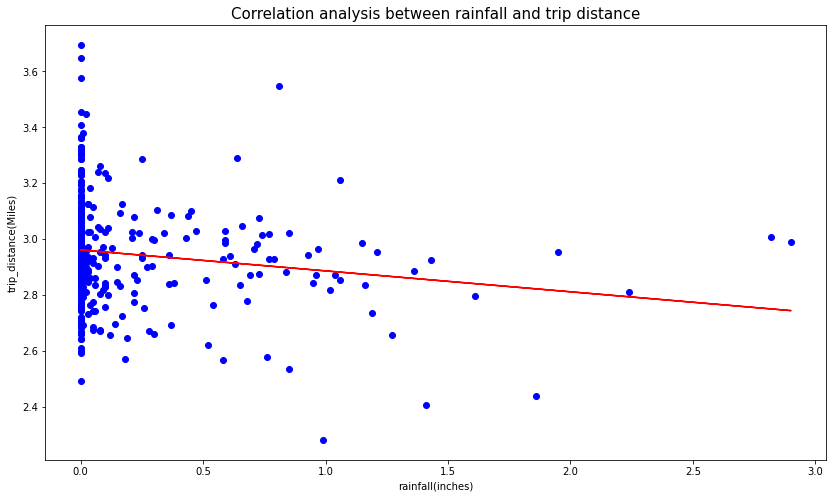

In [92]:
lm2 = smf.ols(formula='trip_distance~PRCP', data = Yellow_2018_Vs_Weather).fit()
#print(lm1.summary())
plt.figure(figsize=(14,8))
plt.plot(Yellow_2018_Vs_Weather['PRCP'], Yellow_2018_Vs_Weather['trip_distance'], 'o',color='blue')
plt.title('Correlation analysis between rainfall and trip distance', fontsize = 15)
plt.xlabel('rainfall(inches)')
plt.ylabel('trip_distance(Miles)')
plt.plot(Yellow_2018_Vs_Weather['PRCP'], lm2.predict(), '-r')

# Step2: two-ways ANNOVA on Yellow and Green taxi(2018 year)

In [68]:
#two-ways ANNOVA 
#year:2018
#data source: yellow taxi
#factors:temperature & snowdepth & rainfall
#responsible variable: total taxifare amount & trip_distance


#raining level: less than 0.1 inch:light rain;between 0.1 and 0.3 inche:moderate rainfall;greater than 0.3 inch:heavy rainfall
#snowdepth:whether or not
def raining_lvl(x):
    if x <=0.1 :
        return 'light'
    elif x>0.1 and x<=0.3:
        return 'moderate'
    else:
        return 'heavy' 
def temp_lvl(x):
    if x<=0:
        return 'cold'
    elif x>0 and x<=26:
        return 'comfortable'
    else: return 'hot'
    
    
    
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.options.display.float_format = '{:.4f}'.format 
np.set_printoptions(suppress=True)
# Performing two-way ANOVA
model = ols('total_amount ~ C(temp_level) + C(raining_level) +\
C(temp_level):C(raining_level)',
            data=Yellow_2018_Vs_Weather).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
print(result)

                                     df   sum_sq  mean_sq       F  PR(>F)
C(temp_level)                    2.0000  27.9010  13.9505 18.0272  0.0000
C(raining_level)                 2.0000   0.8328   0.4164  0.5381  0.5843
C(temp_level):C(raining_level)   4.0000  20.0890   5.0222  6.4899  0.0000
Residual                       356.0000 275.4931   0.7739     NaN     NaN


## the p-value of temperature level is less than 0.05, which indicates that it has significant effect on total taxifare amount

In [70]:
# Performing two-way ANOVA
model = ols('total_amount ~ C(temp_level) + C(ifsnowdepth) +\
C(temp_level):C(ifsnowdepth)',
            data=Yellow_2018_Vs_Weather).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
print(result)

                                   df   sum_sq  mean_sq       F  PR(>F)
C(temp_level)                  2.0000  27.9010  13.9505 17.0008  0.0000
C(ifsnowdepth)                 1.0000   0.9762   0.9762  1.1896  0.2761
C(temp_level):C(ifsnowdepth)   2.0000   0.1281   0.0641  0.0781  0.9249
Residual                     360.0000 295.4087   0.8206     NaN     NaN


In [72]:
# Performing two-way ANOVA
model = ols('trip_distance ~ C(temp_level) + C(ifsnowdepth) +\
C(temp_level):C(ifsnowdepth)',
            data=Yellow_2018_Vs_Weather).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
print(result)

                                   df  sum_sq  mean_sq      F  PR(>F)
C(temp_level)                  2.0000  0.6347   0.3174 8.7524  0.0002
C(ifsnowdepth)                 1.0000  0.0383   0.0383 1.0569  0.3046
C(temp_level):C(ifsnowdepth)   2.0000  0.0033   0.0017 0.0459  0.9552
Residual                     360.0000 13.0541   0.0363    NaN     NaN


## the p-value of temperature level is less than 0.05, which indicates that it has significant effect on trip_distance

In [73]:
# Performing two-way ANOVA
model = ols('trip_distance ~ C(temp_level) + C(raining_level) +\
C(temp_level):C(raining_level)',
            data=Yellow_2018_Vs_Weather).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
print(result)

                                     df  sum_sq  mean_sq      F  PR(>F)
C(temp_level)                    2.0000  0.6347   0.3174 8.9539  0.0002
C(raining_level)                 2.0000  0.4163   0.2082 5.8725  0.0031
C(temp_level):C(raining_level)   4.0000  0.0602   0.0150 0.4243  0.7911
Residual                       356.0000 12.6186   0.0354    NaN     NaN


## the p-value of raining_level is less than 0.05, which indicates that it has significant effect on trip_distance

In [76]:
#two-ways ANNOVA 
#year:2018
#data source: green taxi
#factors:temperature & snowdepth & rainfall
#responsible variable: total taxifare amount
# Performing two-way ANOVA
model = ols('total_amount ~ C(temp_level) + C(raining_level) +\
C(temp_level):C(raining_level)',
            data=green_2018_Vs_Weather).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
print(result)

                                     df   sum_sq  mean_sq       F  PR(>F)
C(temp_level)                    2.0000  76.4278  38.2139 39.4304  0.0000
C(raining_level)                 2.0000   5.3557   2.6778  2.7631  0.0645
C(temp_level):C(raining_level)   4.0000   1.4369   0.3592  0.3706  0.8295
Residual                       356.0000 345.0168   0.9691     NaN     NaN


In [79]:
# Performing two-way ANOVA
model = ols('total_amount ~ C(temp_level) + C(ifsnowdepth) +\
C(temp_level):C(ifsnowdepth)',
            data=green_2018_Vs_Weather).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
print(result)

                                   df   sum_sq  mean_sq       F  PR(>F)
C(temp_level)                  2.0000  76.4278  38.2139 40.6761  0.0000
C(ifsnowdepth)                 1.0000  13.5451  13.5451 14.4178  0.0002
C(temp_level):C(ifsnowdepth)   2.0000   0.0725   0.0363  0.0386  0.9621
Residual                     360.0000 338.2087   0.9395     NaN     NaN


In [77]:
# Performing two-way ANOVA
model = ols('trip_distance ~ C(temp_level) + C(raining_level) +\
C(temp_level):C(raining_level)',
            data=green_2018_Vs_Weather).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
print(result)

                                     df  sum_sq  mean_sq       F  PR(>F)
C(temp_level)                    2.0000  6.0821   3.0410 42.7947  0.0000
C(raining_level)                 2.0000  0.5606   0.2803  3.9443  0.0202
C(temp_level):C(raining_level)   4.0000  0.0836   0.0209  0.2941  0.8818
Residual                       356.0000 25.2978   0.0711     NaN     NaN


In [78]:
# Performing two-way ANOVA
model = ols('trip_distance ~ C(temp_level) + C(ifsnowdepth) +\
C(temp_level):C(ifsnowdepth)',
            data=green_2018_Vs_Weather).fit()
result = sm.stats.anova_lm(model, type=2)
  
# Print the result
print(result)

                                   df  sum_sq  mean_sq       F  PR(>F)
C(temp_level)                  2.0000  6.0821   3.0410 44.8229  0.0000
C(ifsnowdepth)                 1.0000  1.5077   1.5077 22.2228  0.0000
C(temp_level):C(ifsnowdepth)   2.0000  0.0115   0.0057  0.0845  0.9190
Residual                     360.0000 24.4245   0.0678     NaN     NaN


## the result of p-value indicates that both temperature, snowdepth and raining level have significant effect on total taxifare amount and trip_distance

# Step3: two-ways ANCOVA on Yellow and Green taxi(2018 year)

In [84]:
!pip install pingouin

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 185 kB 31.9 MB/s eta 0:00:01
     |████████████████████████████████| 26.4 MB 46.3 MB/s eta 0:00:01
     |████████████████████████████████| 870 kB 129.3 MB/s eta 0:00:01
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Created wheel for pingouin: filename=pingouin-0.5.2-py3-none-any.whl size=196206 sha256=6956db48e4174dc48020c5b51c02efe26842ed0fd1220fa9c99a3fda61e93de1
  Stored in directory: /home/jw6830/.cache/pip/wheels/c0/9f/92/4c574395e1e8e5e08cf73dcb76815a7eaa62921833b6b0f6ad
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=3fd06dd533bc8342b5cf62c497cb884d1cef9eae167142dbbb7b8734438a13c9
  Stored in directory: /home/jw6830/.cache/pip/wheels/04/bb/0d/2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built pingouin littleutils
  Consider ad

In [86]:
#two-ways ANCOVA 
#year:2018
#data source: yellow taxi
#dependent variables:trip_distance
#between:  temperature & snowdepth & rainfall
#Covar:total taxifare amount 

yellow_2018 = pd.read_csv('Yellow_2018_daily.csv')
yellow_2018['PU_Date'] = pd.to_datetime(yellow_2018['PU_Date'])
Yellow_2018_Vs_Weather = pd.merge(yellow_2018, NYC_weather, left_on='PU_Date', right_on='DATE',how='left').drop('DATE',axis=1)

from pingouin import ancova

# Performing two-way ANCOVA
ancova(data=Yellow_2018_Vs_Weather, dv='trip_distance', covar='total_amount', between='temp_level')
  

,Source,SS,DF,F,p-unc,np2
0,temp_level,0.1186,2,1.9527,0.1434,0.0107
1,total_amount,2.1291,1,70.0912,0.0000,0.1626
2,Residual,10.9659,361,NaN,NaN,NaN
